<div class="alert alert-success">
<b>Reviewer's comment V2</b>
	  
Thank you for taking the time to improve the project! Now it's accepted. Keep up the good work on the next sprint!
	  
</div>

**Review**
	  
Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a great job! There's only one small problem that needs to be fixed before the project can be accepted. It should be very straightforward though.

In [1]:
!pip install -q --user --upgrade pandas matplotlib seaborn sklearn scikit-learn scipy

In [2]:
import os, warnings
from pprint import pprint
from IPython.display import display, Markdown

import pandas as pd
import numpy as np
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import cross_validate, HalvingRandomSearchCV
from sklearn.metrics import get_scorer, make_scorer, confusion_matrix
from sklearn.dummy import DummyRegressor

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [3]:
plt.rcParams['figure.figsize'] = (13,7)

In [4]:
random_state = 123

<br>

# Zyfra
***
## efficiency solutions for heavy industry

<br>

In [5]:
def title_md(_title, n=3, u=False):
    """"""
    
    display(Markdown('{} {}'.format('#'*max(min(n, 4), 1), _title) + ('\n***' if u else '\n')))
    
# title_md('aaaa')

In [6]:
def full(data):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(data)

In [7]:
def get_func(func, series, *args, **kwargs):
    if callable(func):
        return func(series, *args, **kwargs)
    elif isinstance(func, str):
        return getattr(series, func)(*args, **kwargs)

In [8]:
def outliers_iqr(data):
    """Returns lower and upper extremes of non-outlier values"""
    
    q1 = data.quantile(.25)
    q3 = data.quantile(.75)
    iqr = q3 - q1
    # print(f'Q1: {q1:.0f}\tQ3: {q3:.0f}\tIQR: {iqr:.0f}')
    
    le = q1 - 1.5*iqr
    ue = q3 + 1.5*iqr
    # print(f'lower extreme: {le:.0f}\tupper extreme: {ue:.0f}')
    
    return le, ue

# outliers_iqr(raw_feed.sum(axis=1))

## Prepare the data

### 1.1. Open the files and look into the data.

In [9]:
!ls

14-integrated_project_2-review1-fix.ipynb
drafts
gold_recovery_full.csv
gold_recovery_test.csv
gold_recovery_train.csv
instruction_en.pdf


In [10]:
train_df = pd.read_csv('gold_recovery_train.csv')

In [11]:
train_df.info(memory_usage='deep', verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Columns: 87 entries, date to secondary_cleaner.state.floatbank6_a_level
dtypes: float64(86), object(1)
memory usage: 12.3 MB


In [12]:
test_df = pd.read_csv('gold_recovery_test.csv')

In [13]:
test_df.info(memory_usage='deep', verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Columns: 53 entries, date to secondary_cleaner.state.floatbank6_a_level
dtypes: float64(52), object(1)
memory usage: 2.7 MB


In [14]:
full_df = pd.read_csv('gold_recovery_full.csv')

In [15]:
full_df.info(memory_usage='deep', verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Columns: 87 entries, date to secondary_cleaner.state.floatbank6_a_level
dtypes: float64(86), object(1)
memory usage: 16.6 MB


In [16]:
def to_date_time(df):
    """"""
    
    df['time'] = pd.to_datetime(df['date'])
    df['date'] = df['time'].astype('datetime64[D]')

In [17]:
to_date_time(train_df)
to_date_time(test_df)
to_date_time(full_df)

In [18]:
_sort = [
    'rougher', 'primary_cleaner', 'secondary_cleaner', 'final',
    'input', 'output', 'state', 'calculation'
]
_sort = dict(zip(_sort,range(len(_sort))))
_sort

{'rougher': 0,
 'primary_cleaner': 1,
 'secondary_cleaner': 2,
 'final': 3,
 'input': 4,
 'output': 5,
 'state': 6,
 'calculation': 7}

In [19]:
recovery_features = [
    'rougher.input.feed_au',
    'rougher.output.tail_au',
    'rougher.output.concentrate_au',
    'primary_cleaner.output.tail_au',
    'primary_cleaner.output.concentrate_au',
    'secondary_cleaner.output.tail_au',
    'final.output.tail_au',
    'final.output.concentrate_au'
]

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Alright, the data was loaded and inspected!
	  
</div>

### 1.2. Check that recovery is calculated correctly.  
Using the training set, calculate recovery for the rougher.output.recovery feature.  
Find the MAE between your calculations and the feature values. Provide findings.  

In [20]:
def simulate_recovery(c, f, t):
    """"""
    
    return ((c * (f - t)) / 
            (f * (c - t))) * 100

In [21]:
def simulate_rougher_concentrate_recovery(data):
    """"""
    
    return simulate_recovery(
        c = data['rougher.output.concentrate_au'],
        f = data['rougher.input.feed_au'],
        t = data['rougher.output.tail_au']
    )

In [22]:
y_true = train_df['rougher.output.recovery']
y_pred = simulate_rougher_concentrate_recovery(train_df)
mae = np.mean(np.abs(y_true - y_pred))

print(mae, np.format_float_positional(mae), sep='\n')

9.303415616264301e-15
0.000000000000009303415616264301


MAE calculated (9e-15) is practically 0.  
The recovery feature is calculated correctly.

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Recovery was validated successfully!
	  
</div>

In [23]:
# def simulate_final_concentrate_recovery(data):
#     """"""
    
#     return simulate_recovery(
#         c = data['final.output.concentrate_au'],
#         f = data['rougher.output.concentrate_au'],
#         t = data['final.output.tail_au']
#     )

# y_true = train_df['final.output.recovery']
# y_pred = simulate_final_concentrate_recovery(train_df)
# mae = np.mean(np.abs(y_true - y_pred).replace({np.inf: np.nan}))

# print(mae, sep='\n')

### 1.3. Analyze the features not available in the test set.  
What are these parameters? What is their type?

In [24]:
def sort_columns(columns):
    """"""
    
    df = pd.DataFrame(
        data=columns.str.split('.').tolist(), 
        columns=['stage', 'parameter_type', 'parameter_name'])
        
    return (df
            .sort_values('parameter_name')
            .sort_values(['stage', 'parameter_type', 'parameter_name'], key=lambda x:x.map(_sort))
            .dropna())

In [25]:
def features_analysis():
    """"""
    
    _green = '\033[92m'
    _red = '\033[91m'
        
    _sorted = sort_columns(train_df.columns)
    # full(_sorted)
    
#     for (stage, parameter_type), values in _sorted.groupby(_group, sort=False):
#         print(f'{stage}.{parameter_type}\n')
#         print(values['parameter_name'].unique())
#         # pprint(values['parameter_name'].unique().tolist())
#         print('\n')
    
    for parameter in map(lambda x:'.'.join(x), _sorted.values):
        print((_green if parameter in test_df.columns else _red) + parameter)
        
features_analysis()

rougher.input.feed_ag
rougher.input.feed_au
rougher.input.feed_pb
rougher.input.feed_rate
rougher.input.feed_size
rougher.input.feed_sol
rougher.input.floatbank10_sulfate
rougher.input.floatbank10_xanthate
rougher.input.floatbank11_sulfate
rougher.input.floatbank11_xanthate
rougher.output.concentrate_ag
rougher.output.concentrate_au
rougher.output.concentrate_pb
rougher.output.concentrate_sol
rougher.output.recovery
rougher.output.tail_ag
rougher.output.tail_au
rougher.output.tail_pb
rougher.output.tail_sol
rougher.state.floatbank10_a_air
rougher.state.floatbank10_a_level
rougher.state.floatbank10_b_air
rougher.state.floatbank10_b_level
rougher.state.floatbank10_c_air
rougher.state.floatbank10_c_level
rougher.state.floatbank10_d_air
rougher.state.floatbank10_d_level
rougher.state.floatbank10_e_air
rougher.state.floatbank10_e_level
rougher.state.floatbank10_f_air
rougher.state.floatbank10_f_level
rougher.calculation.au_pb_ratio
rougher.calculation.floatbank10_sulfate_to_au_feed
rougher.

'output' and 'calculation' parameter types are missing from the test set.  
They are integral to the calculation of the recovery.

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Yep, the important part is that these features are not available before the process is finished, so they shouldn't be used in a model
	  
</div>

### 1.4. Perform data preprocessing

In [26]:
def df_report(df_name):
    """"""
    
    _lj = 8
    
    df = globals()[df_name]
    title_md(df_name)
    print('shape:'.ljust(_lj), df.shape)
    print('size:'.ljust(_lj), f'{df.size:,}')
    
    title_md(f'Missing values', n=4)
    na = df.isna().sum().sort_values(ascending=False)
    na = na[na > 0]
    print('amount:'.ljust(_lj), f'{na.sum():,} ({na.sum() / df.size:.2%})', '\n')
    
    with pd.option_context('display.max_rows', 10, 'display.max_columns', 10):
        display(na)
    
    title_md(f'Duplicates', n=4)
    print('amount:'.ljust(_lj), f'{df.duplicated().sum():,} ({df.duplicated().sum() / df.size:.2%})', '\n')
      
# df_report('train_df')

In [27]:
def date_impute(df, func='mean', **kwargs):
    """"""
    
    _func = lambda x:get_func(func, x, **kwargs)
    df = df.copy()
    ref = df.groupby('date').apply(_func)
    
    def _d(x):
        nonlocal ref
        
        if x.isna().sum():
            # print('daily resolution')
            filled = df['date'].map(ref[x.name])
            
            if filled.isna().sum():
                # print('weekly resolution')
                df['week'] = df['date'].astype('datetime64[W]')
                ref = df.groupby('week').apply(_func)
                filled = df['week'].map(ref[x.name])
                
                if filled.isna().sum():
                    # print('monthly resolution')
                    df['month'] = df['date'].astype('datetime64[M]')
                    ref = df.groupby('month').apply(_func)
                    filled = df['month'].map(ref[x.name])
                    
                    if filled.isna().sum():
                        # print('yearly resolution')
                        df['year'] = df['date'].astype('datetime64[Y]')
                        ref = df.groupby('year').apply(_func)
                        filled = df['year'].map(ref[x.name])
                
            return x.where(~x.isna(), filled)
        else:
            return x
    
    return df.apply(_d)

# date_impute(train_df.iloc[1770:1900][['date', 'time', 'rougher.output.tail_au']]).isna().sum()

In [28]:
def subplots(df, func='plot', cols=3, rows=None, figsize=None, select_dtypes='number'):
    """"""
    
    df = df.select_dtypes(select_dtypes)
    fig = plt.figure(figsize=figsize)#, constrained_layout=True)
    rows = rows or int(np.ceil(len(df.columns)/cols))
    
    for i, col in enumerate(df):
        ax = fig.add_subplot(rows, cols, i+1)
        plt.title(col, fontsize=14)
        get_func(func, df[col])
    
# subplots(day_sample.select_dtypes('number'))

In [29]:
def plot_hists(df, cols=3, rows=None, figsize=None, select_dtypes='number', outliers=False, hook=None, **kwargs):
    """"""
    
    def _plot(series):
        series.hist(**kwargs)
        
        mean = series.mean()
        median = series.median()
        plt.axvline(mean, color='red')
        plt.axvline(median, color='orange')
        legend = [
            f'$\mu =~~~~~~~~~~{mean:.3f}$',
            f'$median = ~{median:.3f}$'
        ]
        
        if outliers:
            le, ue = outliers_iqr(series)
            plt.axvline(le, color='green')
            plt.axvline(ue, color='green')
            legend = [
                *legend,
                f'l_extreme = {le:.2f}',
                f'u_extreme = {ue:.2f}',
            ]
        
        plt.legend(legend)
        
        if callable(hook):
            hook()
    
    subplots(df, _plot, cols=cols, rows=rows, figsize=figsize, select_dtypes=select_dtypes)
    plt.tight_layout()
    
# plot_hists(day_sample.select_dtypes('number'), bins=20)

In [30]:
train_df.shape[0] + test_df.shape[0] == full_df.shape[0]

True

In [31]:
df_report('full_df')

### full_df


shape:   (22716, 88)
size:    1,999,008


#### Missing values


amount:  36,587 (1.83%) 



rougher.output.recovery                               3119
rougher.output.tail_ag                                2737
rougher.output.tail_sol                               2736
rougher.output.tail_au                                2736
rougher.input.floatbank11_xanthate                    2257
                                                      ... 
rougher.calculation.sulfate_to_au_concentrate           44
rougher.calculation.floatbank11_sulfate_to_au_feed      44
primary_cleaner.state.floatbank8_b_level                43
primary_cleaner.state.floatbank8_d_level                43
primary_cleaner.state.floatbank8_c_level                43
Length: 85, dtype: int64

#### Duplicates


amount:  0 (0.00%) 



In [32]:
df_report('train_df')

### train_df


shape:   (16860, 88)
size:    1,483,680


#### Missing values


amount:  30,320 (2.04%) 



rougher.output.recovery                               2573
rougher.output.tail_ag                                2250
rougher.output.tail_sol                               2249
rougher.output.tail_au                                2249
secondary_cleaner.output.tail_sol                     1986
                                                      ... 
primary_cleaner.state.floatbank8_b_level                27
primary_cleaner.state.floatbank8_d_level                27
rougher.calculation.floatbank10_sulfate_to_au_feed      27
rougher.calculation.floatbank11_sulfate_to_au_feed      27
rougher.calculation.sulfate_to_au_concentrate           27
Length: 85, dtype: int64

#### Duplicates


amount:  0 (0.00%) 



In [33]:
df_report('test_df')

### test_df


shape:   (5856, 54)
size:    316,224


#### Missing values


amount:  2,360 (0.75%) 



rougher.input.floatbank11_xanthate            353
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
rougher.input.floatbank10_sulfate             257
primary_cleaner.input.xanthate                166
                                             ... 
rougher.state.floatbank10_a_level              16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
secondary_cleaner.state.floatbank5_b_level     16
Length: 51, dtype: int64

#### Duplicates


amount:  0 (0.00%) 



There are missing values in all of the data sets (1% - 2%).  
There are no duplicated observations.

In [34]:
def analyze_imputation(sample, func='median', figsize=None):
    title_md('Imputation')

    title_md('before', n=4)
    # display(full(day_sample))
    na_before = sample.isna().sum()
    na_cols = na_before[na_before>0].index.tolist()
    print(na_before)
    print()

    title_md('after', n=4)
    imputed = date_impute(sample, func=func)
    print(imputed.isna().sum())
    print()

    subplots(sample[na_cols], figsize=figsize)
    subplots(imputed[na_cols], figsize=figsize)
    
    # plot_hists(sample[na_cols], figsize=figsize)
    # plot_hists(imputed[na_cols], figsize=figsize)
    
# analyze_imputation(one_day_sample, figsize=(25,6))

In [35]:
one_day_sample = train_df.query("'2016-01-19' <= date <= '2016-01-20'"
                               )[['date', 'time', *recovery_features]].set_index('time')

### Imputation


#### before


date                                      0
rougher.input.feed_au                     0
rougher.output.tail_au                   38
rougher.output.concentrate_au             0
primary_cleaner.output.tail_au            0
primary_cleaner.output.concentrate_au     0
secondary_cleaner.output.tail_au          0
final.output.tail_au                      0
final.output.concentrate_au               0
dtype: int64



#### after


date                                     0
rougher.input.feed_au                    0
rougher.output.tail_au                   0
rougher.output.concentrate_au            0
primary_cleaner.output.tail_au           0
primary_cleaner.output.concentrate_au    0
secondary_cleaner.output.tail_au         0
final.output.tail_au                     0
final.output.concentrate_au              0
dtype: int64



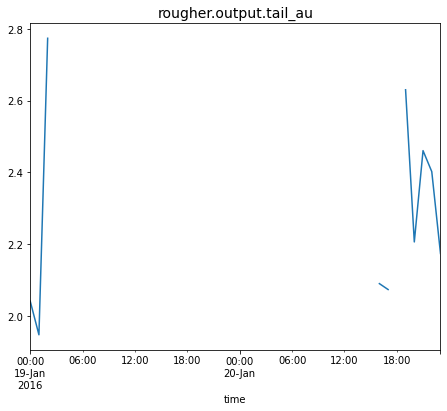

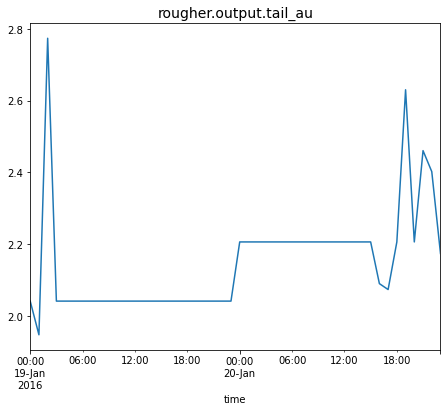

In [36]:
analyze_imputation(one_day_sample, figsize=(25,6))

before: 2249
after:  0


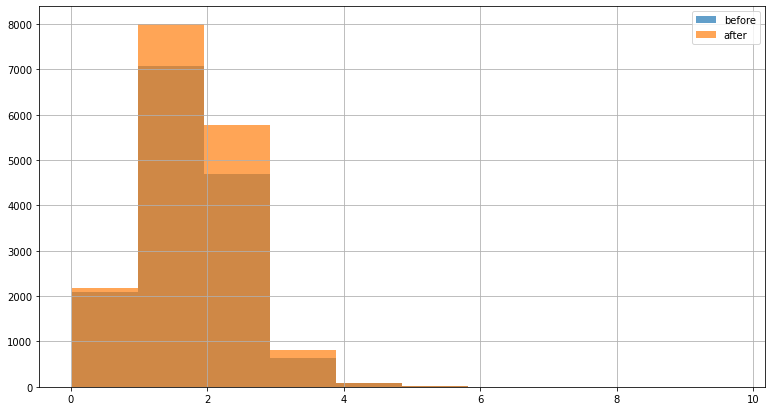

In [37]:
_imputed = date_impute(train_df[['date', 'rougher.output.tail_au']]).iloc[:, -1]

print('before:', train_df['rougher.output.tail_au'].isna().sum())
print('after: ', _imputed.isna().sum())

train_df['rougher.output.tail_au'].hist(alpha=.7)
_imputed.hist(alpha=.7)
plt.legend(['before', 'after'])
plt.show();

Imputing did not alter the distribution, can continue safely.

In [38]:
%%time
train = date_impute(train_df)

print('before:', train_df.isna().sum().sum())
print('after: ', train.isna().sum().sum(), '\n')

before: 30320
after:  0 

CPU times: user 8.49 s, sys: 56 ms, total: 8.55 s
Wall time: 8.56 s


In [39]:
%%time
test = date_impute(test_df)

print('before:', test_df.isna().sum().sum())
print('after: ', test.isna().sum().sum(), '\n')

before: 2360
after:  0 

CPU times: user 1.71 s, sys: 12.1 ms, total: 1.72 s
Wall time: 1.72 s


In [40]:
%%time
full = date_impute(full_df)

print('before:', full_df.isna().sum().sum())
print('after: ', full.isna().sum().sum(), '\n')

before: 36587
after:  0 

CPU times: user 11.2 s, sys: 119 ms, total: 11.3 s
Wall time: 11.3 s


<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Missing values were dealt with reasonably!
	  
</div>

## Analyze the data

### 2.1. Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

In [41]:
def param_lookup(df, search, func='contains', as_list=False, full_df=False):
    """"""
    
    def _lookup():
        return sort_columns(df.columns[getattr(df.columns.str, func)(search)])
    
    def _get_list():
        return list(map(lambda x:'.'.join(x), _lookup().values))
    
    # return df.loc[:, df.columns.str.contains(param)]
    
    if as_list:
        return _get_list()
    elif full_df:
        return df[_get_list()]
    else:
        return _lookup()
    
# param_lookup(train_df, 'feed_size', func='endswith')

In [42]:
def plot_concentrate_dist(df, name, elem, hook=None):
    """"""
    
    plot_hists(
        df[['time', *param_lookup(df, f'concentrate_{elem.lower()}', func='endswith', as_list=True)]],
        figsize=(15, 5),
        hook=hook,
    )
    plt.suptitle(f"{name} ({elem}) concentrate", fontsize=20)
    plt.tight_layout()
    plt.show();
    
# plot_concentrate_dist(train, 'Gold', 'Au')

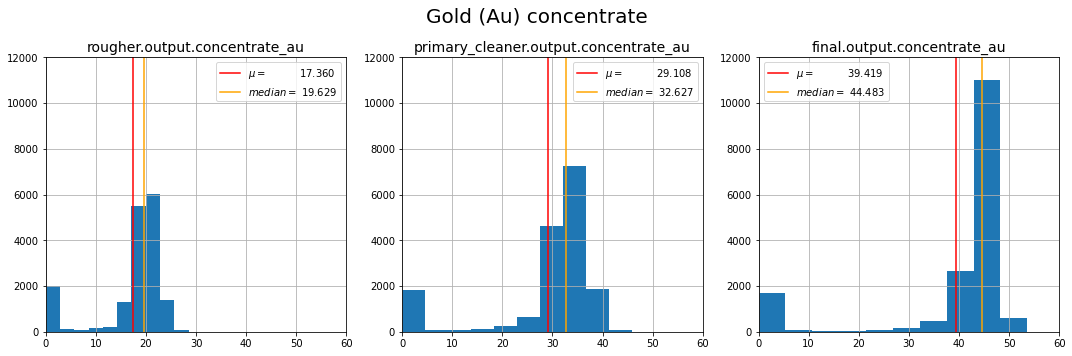

In [43]:
plot_concentrate_dist(train, 'Gold', 'Au', hook=lambda:(plt.ylim((0, 12_000)), plt.xlim((0, 60))))

Gold 'Au' concentrate is considerably increasing from stage to stage.

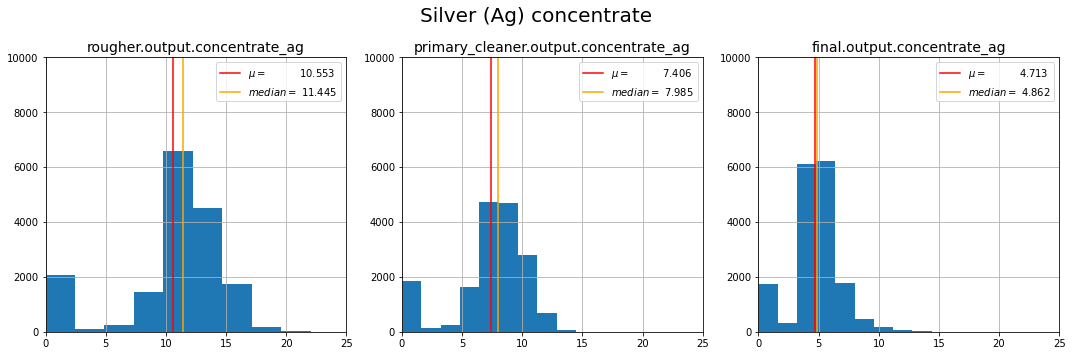

In [44]:
plot_concentrate_dist(train, 'Silver', 'Ag', hook=lambda:(plt.ylim((0, 10_000)), plt.xlim((0, 25))))

Silver 'Ag' concentrate is mildly decreasing from stage to stage.

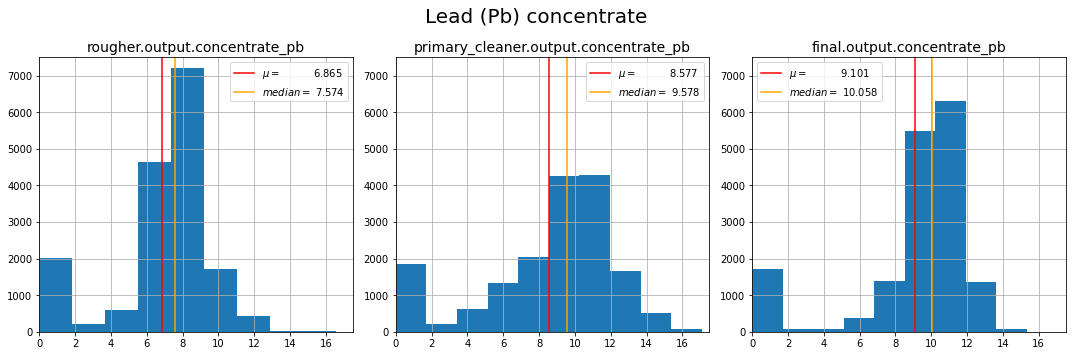

In [45]:
plot_concentrate_dist(train, 'Lead', 'Pb', hook=lambda:(plt.ylim((0, 7_500)), plt.xlim((0, 17.5))))

Lead 'Pb' concentrate is mildly decreasing from stage to stage.

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Great, you compared concentrations of metals at different stages
	  
</div>

### 2.2. Compare the feed particle size distributions in the training set and in the test set.
If the distributions vary significantly, the model evaluation will be incorrect.

In [46]:
train_feed_size = train[param_lookup(train_df, 'feed_size', func='endswith', as_list=True)]

In [47]:
test_feed_size = test[param_lookup(test_df, 'feed_size', func='endswith', as_list=True)]

In [48]:
train_feed_size.columns.tolist()

['rougher.input.feed_size', 'primary_cleaner.input.feed_size']

In [49]:
def compare_feed_size(train, test, func='hist', figsize=(16,6), **kwargs):
    """"""
    
    cols = min(3, train.shape[1])
    rows = int(np.ceil(train.shape[1] / cols))
    
    _, axes = plt.subplots(rows, cols, figsize=figsize)
    
    for col, ax in zip(train, axes):
        if func == 'boxplot':
            df = pd.concat([train[col], test[col]], axis=1)
            _func = getattr(df, func)
            _func(ax=ax)
        else:
            _func = getattr(ax, func)
            _func(train[col], **kwargs)
            _func(test[col], **kwargs)
        
        ax.set_title(col)
        ax.grid()
        ax.legend(['train', 'test'])
        
    return
    train_df_feed_size[col].hist()
    test_df_feed_size[col].hist()
    plt.legend(['train', 'test'])
    plt.title(f'{col} - train vs. test distribution', fontsize=20)
    plt.show()
    
# compare_feed_size(train_feed_size, test_df_feed_size)

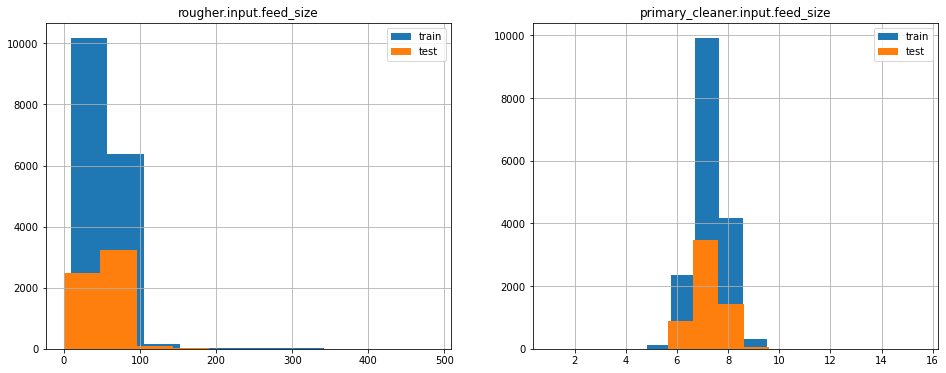

In [50]:
compare_feed_size(train_feed_size, test_feed_size, bins=10)

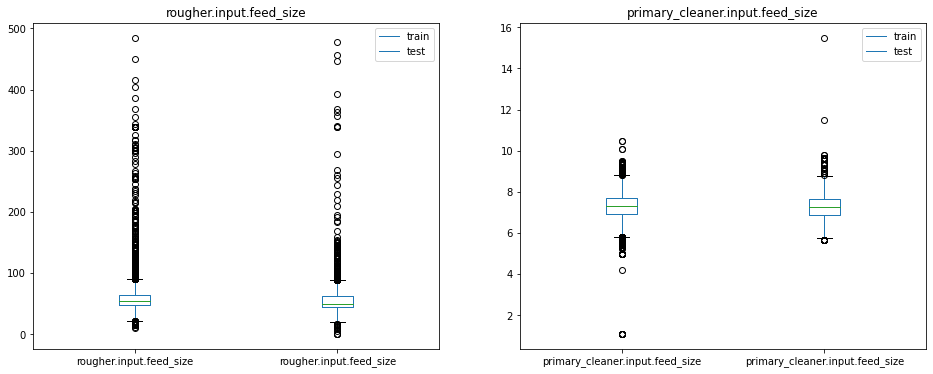

In [51]:
compare_feed_size(train_feed_size, test_feed_size, func='boxplot')

The distributions seem to be similar.  
Performing a statistical test to compare distributions, to make sure.

In [52]:
def ks_test(data1, data2, alternative='two-sided', alpha=.05):
    """
    null hypothesis - identical distributions
    alternative hypothesis - differing distributions
    """
    
    pvalue = ks_2samp(data1, data2, alternative=alternative).pvalue
    
    if pvalue < alpha:
        return "reject null hypothesis - distributions are different"
    else:
        return "can't reject null hypothesis - distribution is the same"
    
# ks_test(train_feed_size['rougher.input.feed_size'], test_feed_size['rougher.input.feed_size'])

In [53]:
title_md('Kolmogorov-Smirnov test')

for col in train_feed_size:
    print(col)
    print(ks_test(train_feed_size[col], test_feed_size[col]))
    print()

### Kolmogorov-Smirnov test


rougher.input.feed_size
reject null hypothesis - distributions are different

primary_cleaner.input.feed_size
reject null hypothesis - distributions are different



Even though the distributions might look similar, the statistical test concluded that they are in fact different.

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Particle size distributions were compared. Yeah, I don't think the author considered that you would be doing a statistical test :D
	  
</div>

### 2.3. Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate.
Do you notice any abnormal values in the total distribution?  
If you do, is it worth removing such values from both samples?  
Describe the findings and eliminate anomalies. 

In [54]:
def inspect_outliers(df, title):
    """"""
    
    display(Markdown('<br>'))
    title_md(f'{title} - anomalies analysis\n***')
    display(df.describe())
    
    plot_hists(df, outliers=True)
    plt.show()
    
    df.boxplot(figsize=(8,5))
    plt.title(f'{title} distribution')
    plt.tight_layout()
    plt.show()
    
    df.sum(axis=1).plot.box(figsize=(8, 5))
    plt.title(f'Combined {title} distribution')
    plt.show()
    
# inspect_outliers(raw_feed, 'rougher.input.feed_*')

In [55]:
raw_params = [e for e in
                param_lookup(train, 'rougher.input.feed_', as_list=True)
                if not 'rate' in e and not 'size' in e]

In [56]:
raw_feed = train[raw_params]
raw_feed.head(2)

,rougher.input.feed_ag,rougher.input.feed_au,rougher.input.feed_pb,rougher.input.feed_sol
0,6.100378,6.486150,2.284912,36.808594
1,6.161113,6.478583,2.266033,35.753385


<br>

### rougher.input.feed_* - anomalies analysis
***


,rougher.input.feed_ag,rougher.input.feed_au,rougher.input.feed_pb,rougher.input.feed_sol
count,16860.000000,16860.000000,16860.000000,16860.000000
mean,7.812979,7.151649,3.202240,32.509670
std,3.145893,3.008689,1.476274,11.694932
min,0.000000,0.000000,0.000000,0.000000
25%,6.877314,6.176626,2.522464,32.014346
50%,7.926186,7.429134,3.276409,36.285846
75%,9.816174,8.954083,4.166485,38.999617
max,14.869652,14.093363,7.142594,48.363177


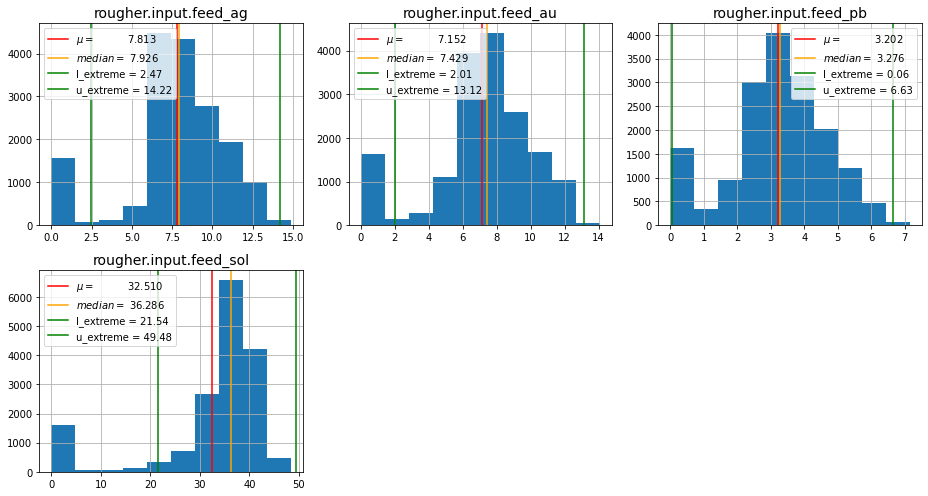

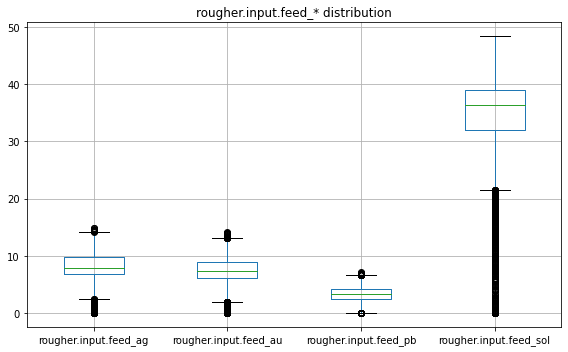

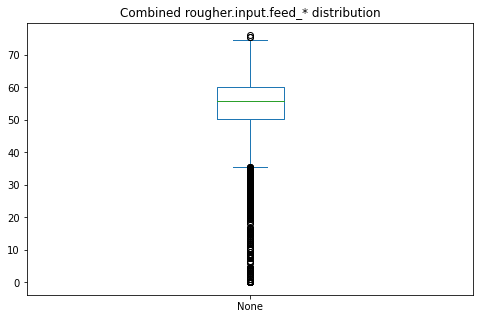

In [57]:
inspect_outliers(raw_feed, 'rougher.input.feed_*')

There are visible outliers.

In [58]:
rougher_conc = param_lookup(train, 'rougher.output.concentrate_', full_df=True)
rougher_conc.head(2)

,rougher.output.concentrate_ag,rougher.output.concentrate_au,rougher.output.concentrate_pb,rougher.output.concentrate_sol
0,11.500771,19.793808,7.101074,28.029297
1,11.615865,20.050975,7.278807,28.067063


<br>

### rougher.output.concentrate_* - anomalies analysis
***


,rougher.output.concentrate_ag,rougher.output.concentrate_au,rougher.output.concentrate_pb,rougher.output.concentrate_sol
count,16860.000000,16860.000000,16860.000000,16860.000000
mean,10.552670,17.360263,6.865338,25.296513
std,4.461763,6.937616,2.931847,10.434934
min,0.000000,0.000000,0.000000,0.000000
25%,9.947304,17.400564,6.326960,24.617062
50%,11.444875,19.629368,7.573731,28.761187
75%,13.267408,21.218314,8.497165,31.518818
max,24.480271,28.522811,18.394042,40.089993


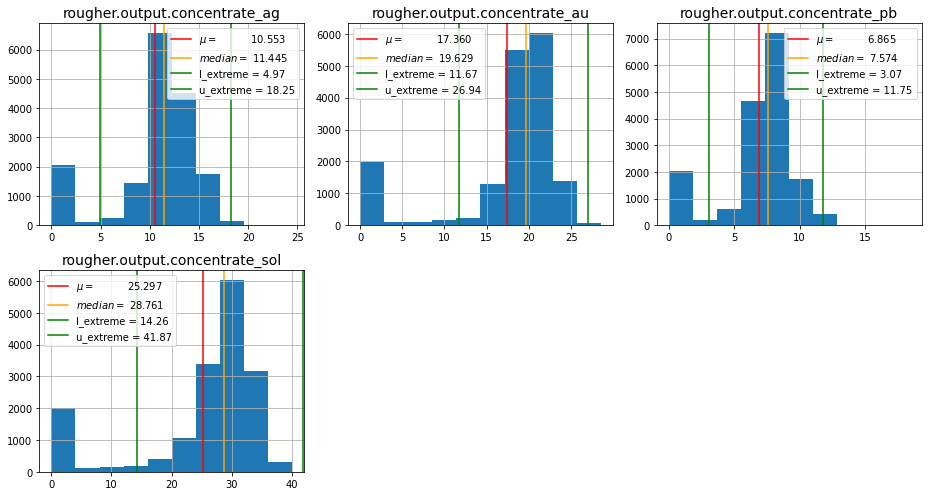

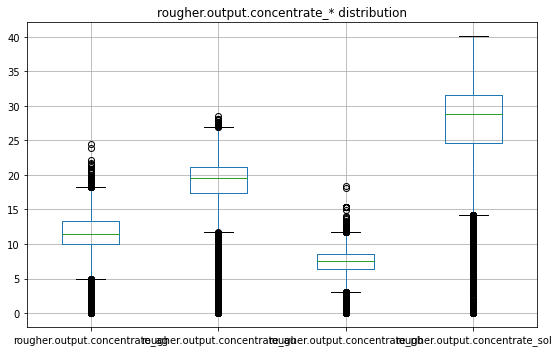

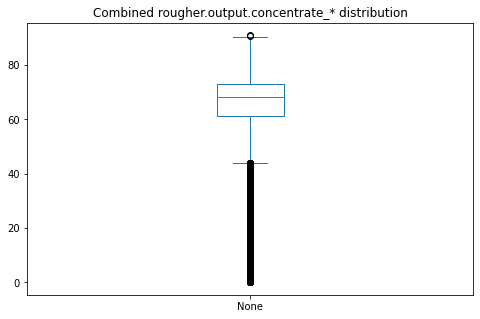

In [59]:
inspect_outliers(rougher_conc, 'rougher.output.concentrate_*')

There are visible outliers.

In [60]:
final_conc = param_lookup(train, 'final.output.concentrate_', full_df=True)
final_conc.head(2)

,final.output.concentrate_ag,final.output.concentrate_au,final.output.concentrate_pb,final.output.concentrate_sol
0,6.055403,42.192020,9.889648,5.507324
1,6.029369,42.701629,9.968944,5.257781


<br>

### final.output.concentrate_* - anomalies analysis
***


,final.output.concentrate_ag,final.output.concentrate_au,final.output.concentrate_pb,final.output.concentrate_sol
count,16860.000000,16860.000000,16860.000000,16860.000000
mean,4.712608,39.418554,9.101451,8.238943
std,2.094382,13.919860,3.390304,3.816679
min,0.000000,0.000000,0.000000,0.000000
25%,3.960984,41.992157,8.807432,6.819672
50%,4.861526,44.483470,10.058013,8.498186
75%,5.816950,45.969495,11.049568,10.246206
max,16.001945,53.611374,17.031899,18.124851


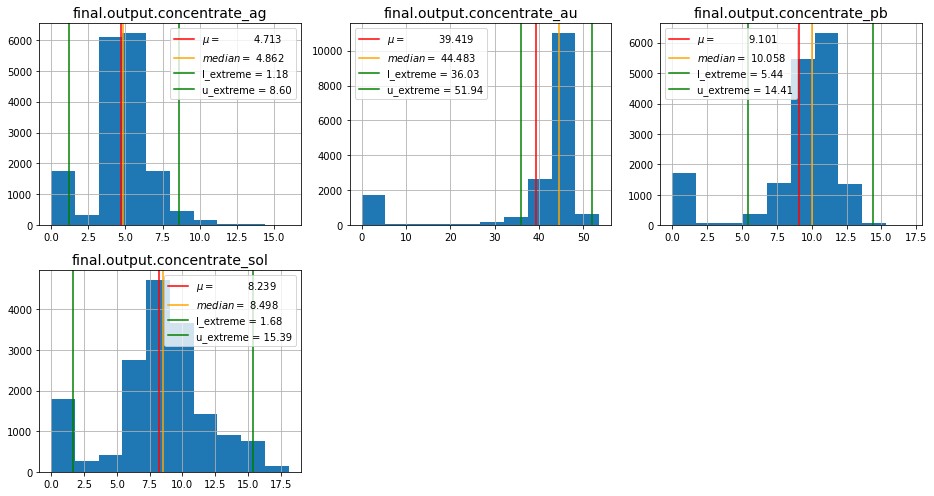

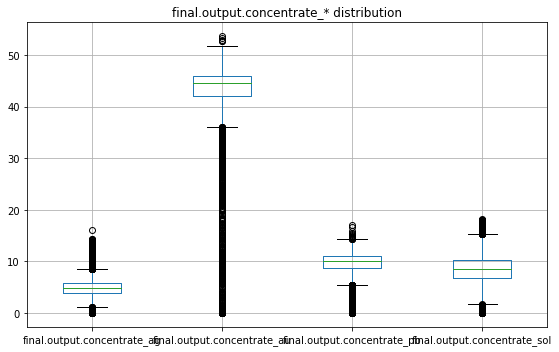

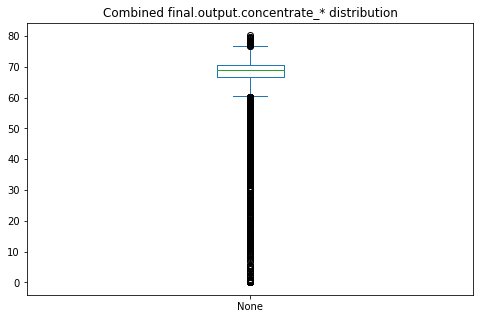

In [61]:
inspect_outliers(final_conc, 'final.output.concentrate_*')

There are visible outliers.

All of the stages show outliers.

In [62]:
def get_outliers_indices(data, quantiles=[]):
    """"""
    
    series = data.sum(axis=1)
    
    if quantiles:
        le = series.quantile(quantiles[0])
        ue = series.quantile(quantiles[1])
    else:
        le, ue = outliers_iqr(series)
    outliers = series[(series < le) | (series > ue)]
    
    return outliers.index

# get_outliers_indices(raw_feed)

In [63]:
def remove_outliers(df, quantiles=(.1, 1)):
    """"""
    
    raw_params = [e for e in
                param_lookup(df, 'rougher.input.feed_', as_list=True)
                if not 'rate' in e and not 'size' in e]
    
    raw_feed = df[raw_params]
    rougher_conc = param_lookup(df, 'rougher.output.concentrate_', full_df=True)
    final_conc = param_lookup(df, 'final.output.concentrate_', full_df=True)
    
    relevant = pd.concat([
        raw_feed,
        rougher_conc,
        final_conc,
    ], axis=1)
    
    
    if quantiles:
        outliers_indices = get_outliers_indices(relevant, quantiles=quantiles)
        print(f'outliers ratio (quantiles):\t{len(outliers_indices) / len(train_df):.2f}')
    else:
        outliers_indices = get_outliers_indices(relevant)
        print(f'outliers ratio (iqr):\t\t{len(outliers_indices) / len(train_df):.2f}')
    
    print()
    
    clean = df[~df.index.isin(outliers_indices)]
    print('shape before:\t\t', df.shape)
    print('shape after:\t\t', clean.shape)
    print()
    
    removed = len(df)-len(clean)
    print(f'outliers removed:\t{removed:,} ({removed/len(df):.0%})')
    
    return clean

# remove_outliers(train)

In [64]:
train_clean = remove_outliers(train)

outliers ratio (quantiles):	0.10

shape before:		 (16860, 88)
shape after:		 (15181, 88)

outliers removed:	1,679 (10%)


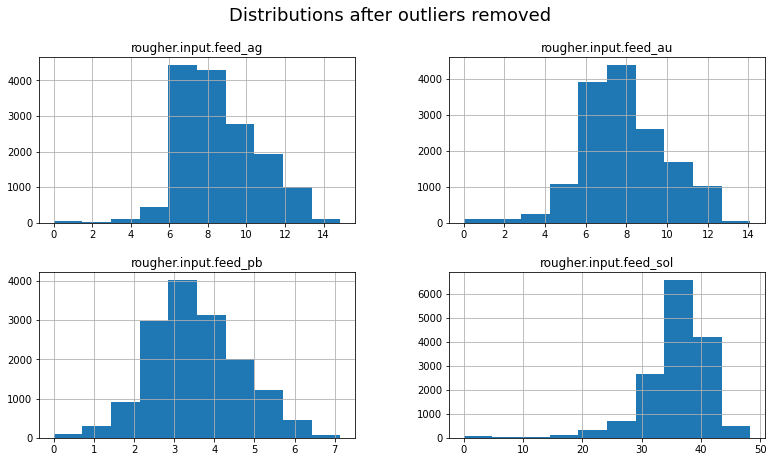

In [65]:
train_clean[raw_params].hist()
plt.suptitle('Distributions after outliers removed', fontsize=18)
plt.show()

Anomalies have been cleaned successfully.

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Outliers were detected and removed!
	  
</div>

<div class="alert alert-info">
<b>Student's comment v.1</b>
    
  I wasn't happy with the results of the models, <br>
  got a hint from our tutors to try and eliminate outliers by taking into account the target features.
    
  It got me a reasonable improvement, ~2 sMAPE.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>
	  
Not a bad idea! By the way, I think, the thing with not getting much improvement over the baseline is an intended outcome of this project (sometimes machine learning can't help much: for example maybe there is some variable that we don't have access to that determines the target). On the other hand it shows an importance of having a baseline: looking at the model's scores in isolation, it may seem that it's performing reasonably well, but if we compare it to some simple baseline, it may turn out that the model didn't learn anything non-trivial (and we wouldn't know that otherwise!).
	  
</div>

In [66]:
train_clean = (lambda df:(
                lambda x:df[~df.index.isin(x)]#[['rougher.output.recovery', 'final.output.recovery']].hist()
                )(get_outliers_indices(param_lookup(df, 'recovery', full_df=True), quantiles=(.1, .8)))
              )(train)#train_df.fillna(method='ffill')

## 3. Build the model

### 3.1. Write a function to calculate the final sMAPE value.

<div class="alert alert-info">
<b>Student's comment v.1</b>
    
  Another student pointed out a mistake in my sMAPE function, forgot parenthesis:
    np.abs(y_true) + np.abs(y_pred) / 2
    
  Updated with a proper version.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>
	  
Oh, my bad for missing this! Sorry!
	  
</div>

In [67]:
def sMAPE(y_true, y_pred):
    """"""

#     return (100 / len(y_true) * 
#             np.sum(np.abs(y_true - y_pred) /
#                    (np.abs(y_true) + np.abs(y_pred) / 2)))

    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# sMAPE(train_df['rougher.output.recovery'],
#       simulate_rougher_concentrate_recovery(train_df))

In [68]:
smape_scorer = make_scorer(lambda *args:np.sum(sMAPE(*args) * [.25, .75]), greater_is_better=False)
# smape_scorer._score_func(y_test, y_pred)

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Smape calculation is correct
	  
</div>

In [69]:
def score_report(y_true, y_pred, verbose=False):
    """"""
    
    smape = sMAPE(y_true, y_pred).rename('sMAPE')
    if verbose:
        display(smape.round(2))
    
    final = smape_scorer._score_func(y_true, y_pred)
    print(f'final sMAPE (.25 + .75):\t{final:.2f}')

    return final

# score_report(y_test, y_pred);

In [70]:
def run_model(model_class, hyperparams=None, wrap_multi=False, *args, **kwargs):
    """"""
    
    def _set_params(**kwargs): 
        try:
            model.set_params(**kwargs)
        except:
            pass
    
    model = model_class(*args, **kwargs)
    model_name = model_class.__name__
    title_md(model_name)
    
    _set_params(random_state=random_state)
    _set_params(n_jobs=-1)
    
    if wrap_multi:
        model = MultiOutputRegressor(model, n_jobs=-1)    
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        # ('scaler', MinMaxScaler()),
        ('rg', model),
    ])
        
    if hyperparams:
        print(pipeline, '\n')
        
        if wrap_multi:
            hyperparams = { 'rg__estimator__'+k: v for k, v in hyperparams.items() }
        else:
            hyperparams = { 'rg__'+k: v for k, v in hyperparams.items() }
        
        search = HalvingRandomSearchCV(pipeline,
                                       hyperparams,
                                       scoring=smape_scorer,
                                       n_jobs=-1,
                                       random_state=random_state)
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            search.fit(X_train, y_train)
        
        pipeline = search.best_estimator_
        pprint(search.best_params_, width=1, sort_dicts=False)
        print(f'\ntrain score: {np.abs(search.best_score_):.2f}')
    else:
        print(pipeline, '\n')
        pipeline.fit(X_train, y_train)
        cv_results = cross_validate(pipeline, X_train, y_train, scoring=smape_scorer, n_jobs=-1)
        print('cross-validate:')
        pprint(cv_results, width=1, sort_dicts=False)
    
    y_pred = pipeline.predict(X_test)
    
    return score_report(y_test, y_pred, verbose=True)


# run_model(LinearRegression)
# run_model(RandomForestRegressor, {
#     'n_estimators': [100, 110, 120, 130],
#     'max_depth': [None, 2, 5, 10],
# })

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
The function for model training, hyperparameter tuning and final model evaluation is great!
	  
</div>

In [71]:
target = ['rougher.output.recovery', 'final.output.recovery']

In [72]:
X_train = train_clean.drop(['date',
                            'time',
                            *train.columns.symmetric_difference(test.columns),
                            *target,
                           ], axis=1)
y_train = train_clean[target]

In [73]:
X_test = test.drop(['date', 'time'], axis=1)
y_test = full.loc[test.index, target]

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>
	  
Using a symmetric difference of train and test columns means that you are excluding the common columns of train and test, but including the columns that are only present in the train set (the 'output' and 'calculation' type columns that could cause target leakage) — which is the opposite of what we wanted :)
	  
</div>

In [74]:
# print(train.columns.symmetric_difference(test.columns))
# print(X_train.columns)
# print(X_test.columns)
X_train.columns == X_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

<div class="alert alert-info">
<b>Student's comment v.1</b>
    
  I was actually excluding the difference (dropping the columns that are only in the train set, but not in the test set). <br>
  Perhaps I did so in a roundabout and confusing way, below is a more straight forward approach.
</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>
	  
Oh, I'm so sorry about that! That's definitely a valid way, I just didn't realize you were dropping the symmetric difference for some reason. Maybe I was looking at the next line and mixed them up? Again, sorry about that!  
	  
</div>

In [75]:
X_train = train_clean[X_test.columns]

In [76]:
X_train.columns == X_test.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [77]:
title_md('Dummy model (baseline)')
for s in ['mean', 'median']:
    print(s)
    score_report(y_test, DummyRegressor(strategy=s).fit(X_train, y_train).predict(X_test))
    print()

### Dummy model (baseline)


mean
final sMAPE (.25 + .75):	11.60

median
final sMAPE (.25 + .75):	11.73



<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Great, there is a simple baseline!
	  
</div>

In [78]:
run_model(LinearRegression);

### LinearRegression


Pipeline(steps=[('scaler', StandardScaler()),
                ('rg', LinearRegression(n_jobs=-1))]) 

cross-validate:
{'fit_time': array([0.04114723, 0.05054903, 0.05088711, 0.05589294, 0.05312729]),
 'score_time': array([0.00535488, 0.00772381, 0.00682688, 0.00818181, 0.00615883]),
 'test_score': array([-7.10832165, -6.84968169, -5.7542518 , -6.90210938, -8.15116192])}


rougher.output.recovery    13.18
final.output.recovery      12.25
Name: sMAPE, dtype: float64

final sMAPE (.25 + .75):	12.48


In [79]:
run_model(Lasso, {
    'selection': ['cyclic', 'random'],
    'max_iter': [100, 300, 500, 700, 900, 1000],
    'tol': [1e-4, 1e-2, 1],
    'alpha': [1, 1.2, 0.1],
});

### Lasso


Pipeline(steps=[('scaler', StandardScaler()), ('rg', Lasso(random_state=123))]) 

{'rg__tol': 0.01,
 'rg__selection': 'random',
 'rg__max_iter': 700,
 'rg__alpha': 1}

train score: 6.53


rougher.output.recovery    12.56
final.output.recovery      11.61
Name: sMAPE, dtype: float64

final sMAPE (.25 + .75):	11.85


In [80]:
run_model(ElasticNet, {
    'selection': ['cyclic', 'random'],
    'max_iter': [100, 300, 500, 700, 900, 1000,],
    'tol': [1e-4, 1e-2, 1],
    'alpha': [1e-2, 1e-1, .5, 1, 1.1],
});

### ElasticNet


Pipeline(steps=[('scaler', StandardScaler()),
                ('rg', ElasticNet(random_state=123))]) 

{'rg__tol': 0.0001,
 'rg__selection': 'random',
 'rg__max_iter': 500,
 'rg__alpha': 1.1}

train score: 6.55


rougher.output.recovery    12.73
final.output.recovery      11.67
Name: sMAPE, dtype: float64

final sMAPE (.25 + .75):	11.93


In [81]:
run_model(BayesianRidge, {
    'n_iter': [100, 300, 500, 1000],
    'tol': [1e-5, 1e-4, 1e-3],
    'alpha_1': [1e-5, 1e-4],
    'alpha_2': [1e-5, 1e-4],
    'lambda_1': [ 1e-5, 1e-4],
    'lambda_2': [ 1e-5, 1e-4],
}, wrap_multi=True);

### BayesianRidge


Pipeline(steps=[('scaler', StandardScaler()),
                ('rg',
                 MultiOutputRegressor(estimator=BayesianRidge(), n_jobs=-1))]) 

{'rg__estimator__tol': 0.0001,
 'rg__estimator__n_iter': 300,
 'rg__estimator__lambda_2': 1e-05,
 'rg__estimator__lambda_1': 1e-05,
 'rg__estimator__alpha_2': 1e-05,
 'rg__estimator__alpha_1': 1e-05}

train score: 6.86


rougher.output.recovery    13.18
final.output.recovery      12.24
Name: sMAPE, dtype: float64

final sMAPE (.25 + .75):	12.47


In [82]:
run_model(DecisionTreeRegressor, {
    'max_depth': [None, 2, 5, 10, 15, 20],
    'max_features': [None, 10, 20, 30],
});

### DecisionTreeRegressor


Pipeline(steps=[('scaler', StandardScaler()),
                ('rg', DecisionTreeRegressor(random_state=123))]) 

{'rg__max_features': None,
 'rg__max_depth': 2}

train score: 6.25


rougher.output.recovery    14.17
final.output.recovery      11.86
Name: sMAPE, dtype: float64

final sMAPE (.25 + .75):	12.44


In [83]:
run_model(RandomForestRegressor, {
    'n_estimators': [100, 110, 120, 130],
    'max_depth': [None, 2, 5, 10],
    'max_features': [None, 10, 20, 30],
});

### RandomForestRegressor


Pipeline(steps=[('scaler', StandardScaler()),
                ('rg', RandomForestRegressor(n_jobs=-1, random_state=123))]) 

{'rg__n_estimators': 130,
 'rg__max_features': 20,
 'rg__max_depth': 5}

train score: 7.01


rougher.output.recovery    13.68
final.output.recovery      11.94
Name: sMAPE, dtype: float64

final sMAPE (.25 + .75):	12.38


In [84]:
run_model(GradientBoostingRegressor, {
    # 'loss': ['squared_error', 'ls', 'absolute_error', 'lad', 'huber'],
    'n_estimators': [100, 110, 120, 130],
    'max_depth': [None, 2, 5, 10],
    # 'max_features': [None, 10, 20, 30],
    # 'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
}, wrap_multi=True);

### GradientBoostingRegressor


Pipeline(steps=[('scaler', StandardScaler()),
                ('rg',
                 MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=123),
                                      n_jobs=-1))]) 

{'rg__estimator__n_estimators': 120,
 'rg__estimator__max_depth': 2}

train score: 10.29


rougher.output.recovery    13.77
final.output.recovery      12.03
Name: sMAPE, dtype: float64

final sMAPE (.25 + .75):	12.46


Best (lowest) sMAPE score we got is 11.85, using Lasso Regressor.  
The train score is 6.53, which indicates we have an overfit model.

It performs just a little bit worse than our dummy model (11.60), which predicts using mean of target. 

We need better data (or processing of) to provide meaningful results.

<div class="alert alert-success">
<b>Reviewer's comment</b>
	  
Excellent, you tried a few different models and tuned their hyperparameters using cross-validation
	  
</div>